In [210]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import mir_eval
import scipy
import librosa
import tqdm
import copy

import models
import datasets
import oracles
import metrics
import utils
import change_point_detection as cpd
import query_strategies as qs
import evaluate
import visualize

import metrics

import matplotlib.pyplot as plt
import matplotlib

In [212]:
def list_difference(l1, l2):
    return list(set(l1).difference(l2))

In [213]:
ls /mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me/train_soundscapes_snr_0.0

soundscape_0.birdnet.embeddings.txt   soundscape_32.birdnet.embeddings.txt
soundscape_0.jams                     soundscape_32.jams
soundscape_0.txt                      soundscape_32.txt
soundscape_0.wav                      soundscape_32.wav
soundscape_10.birdnet.embeddings.txt  soundscape_33.birdnet.embeddings.txt
soundscape_10.jams                    soundscape_33.jams
soundscape_10.txt                     soundscape_33.txt
soundscape_10.wav                     soundscape_33.wav
soundscape_11.birdnet.embeddings.txt  soundscape_34.birdnet.embeddings.txt
soundscape_11.jams                    soundscape_34.jams
soundscape_11.txt                     soundscape_34.txt
soundscape_11.wav                     soundscape_34.wav
soundscape_12.birdnet.embeddings.txt  soundscape_35.birdnet.embeddings.txt
soundscape_12.jams                    soundscape_35.jams
soundscape_12.txt                     soundscape_35.txt
soundscape_12.wav                     soundscape_35.wav
soundscape_13.birdnet.em

In [266]:
snr = '0.0'
base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me/train_soundscapes_snr_{}/'.format(snr)
n_soundscapes = 50

query_strategy_0 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=False, fixed_queries=False)
query_strategy_1 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=False)
query_strategy_2 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=False, fixed_queries=True)
query_strategy_3 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=True)

all_soundscape_basenames = ['soundscape_{}'.format(idx) for idx in range(n_soundscapes)]
init_idx = 25
init_soundscape_basename = all_soundscape_basenames[init_idx]

print(init_soundscape_basename)

# initialize strategies with ground truth labels for supplied soundscape
query_strategy_0.initialize_with_ground_truth_labels(init_soundscape_basename)
query_strategy_1.initialize_with_ground_truth_labels(init_soundscape_basename)
query_strategy_2.initialize_with_ground_truth_labels(init_soundscape_basename)
query_strategy_3.initialize_with_ground_truth_labels(init_soundscape_basename)

remaining_soundscape_basenames = list_difference(all_soundscape_basenames, [init_soundscape_basename])
remaining_soundscape_basenames = sorted(remaining_soundscape_basenames)
#np.random.shuffle(remaining_soundscape_basenames)

bns_s0 = copy.copy(remaining_soundscape_basenames)
bns_s1 = copy.copy(remaining_soundscape_basenames)
bns_s2 = copy.copy(remaining_soundscape_basenames)
bns_s3 = copy.copy(remaining_soundscape_basenames)

assert(bns_s0 == bns_s1 == bns_s2 == bns_s3)
assert(len(bns_s0) == n_soundscapes-1)

soundscape_25


In [276]:
soundscape_basename = remaining_soundscape_basenames[12]
n_queries = 7

# Strategy 0: active soundscape, active queries

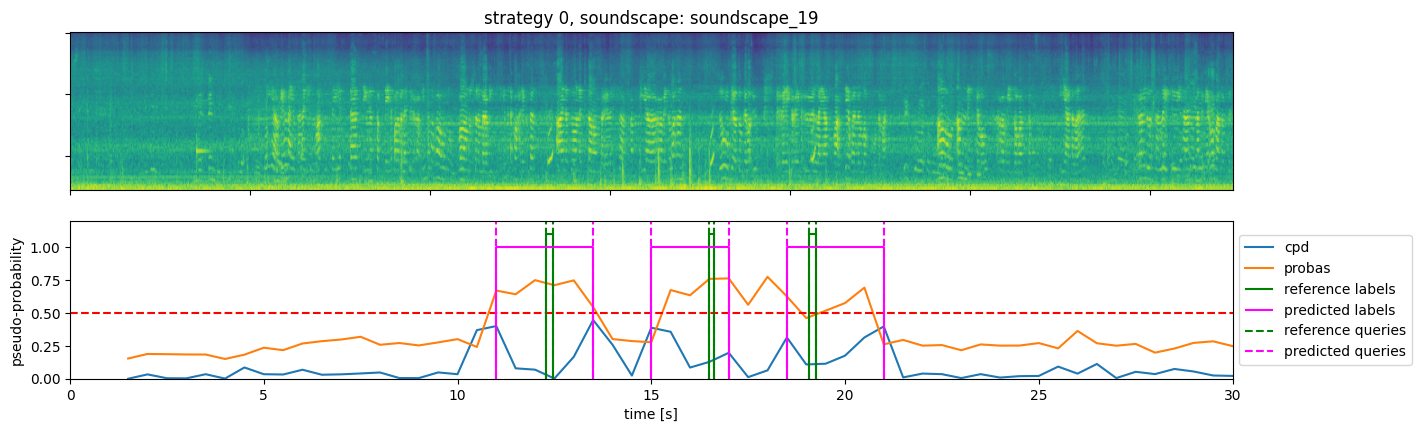

In [279]:
soundscape_basename = query_strategy_0.next_soundscape_basename(remaining_soundscape_basenames)
visualize.visualize_query_strategy(query_strategy_0, "strategy 0", soundscape_basename, base_dir, n_queries, vis_probs=True)

# Strategy 3: random soundscape, fixed queries

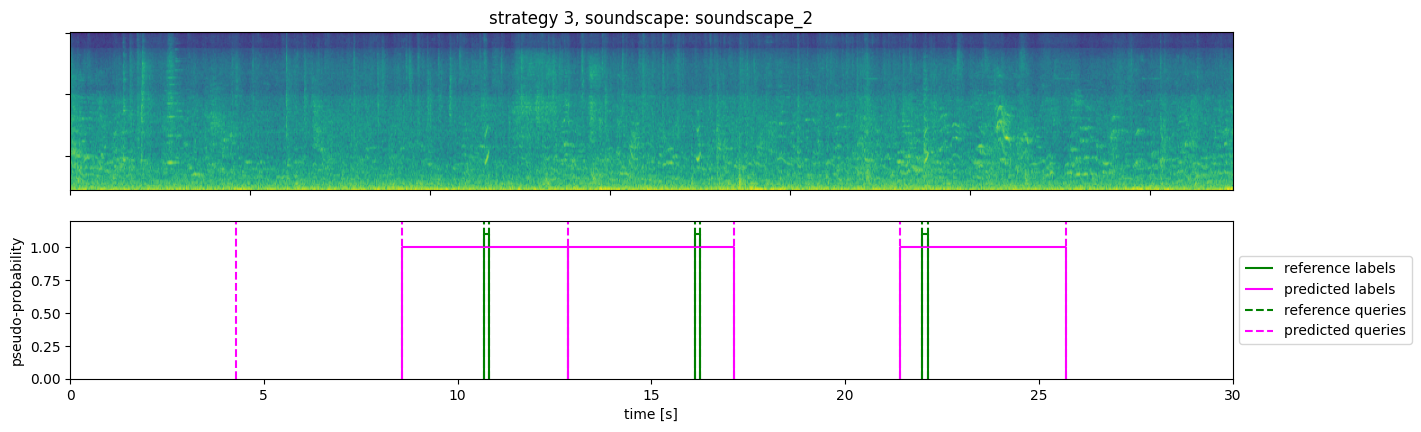

In [278]:
visualize.visualize_query_strategy(query_strategy_3, "strategy 3", soundscape_basename, base_dir, n_queries, vis_probs=False)

# Strategy 1: random soundscape, active queries

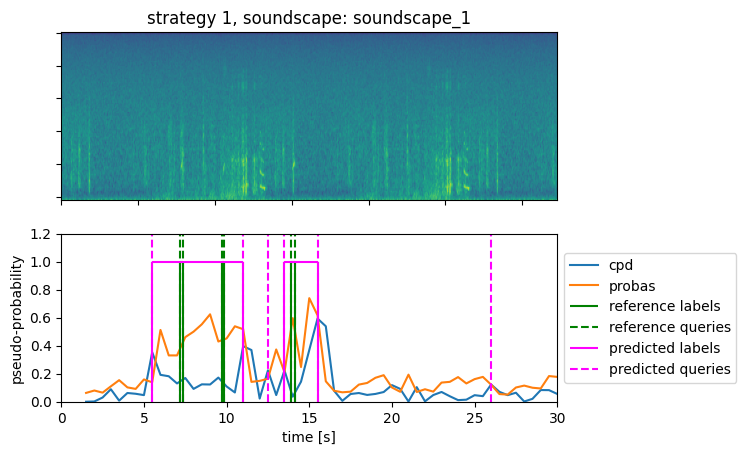

In [17]:
visualize.visualize_query_strategy(query_strategy_1, "strategy 1", soundscape_basename, base_dir)

# Strategy 2: active soundscape, fixed queries

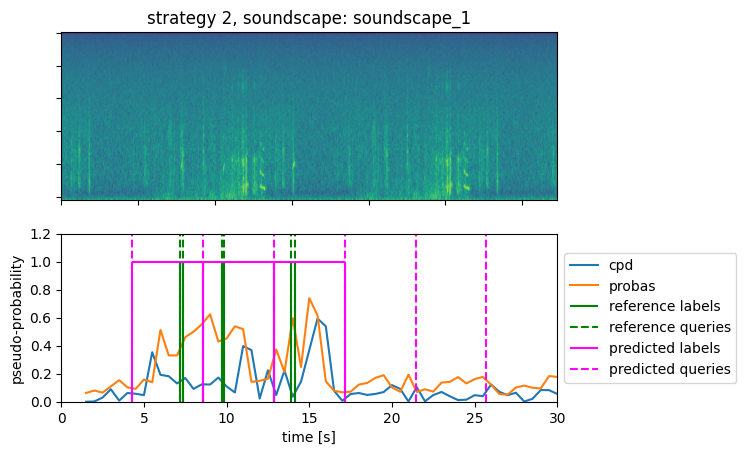

In [18]:
visualize.visualize_query_strategy(query_strategy_2, "strategy 2", soundscape_basename, base_dir)

# SNR normalization

In [91]:
from scaper.audio import get_integrated_lufs
import librosa

In [171]:
ref_db = -10 # LUFS

bg_event, sr = librosa.load('/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_source/background/bg/ME2_26.wav')
fg_event, sr = librosa.load('/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_source/foreground/fg/ME2_13.wav')

bg_event = np.expand_dims(bg_event, axis=1)
fg_event = np.expand_dims(fg_event, axis=1)

bg_energy = np.mean(bg_event**2)
fg_energy = np.mean(fg_event**2)

snr_power = fg_energy / bg_energy
snr_db    = 10*np.log10(snr_power)

print("ref_db         = {}".format(ref_db))
#print("SNR_power    = {}".format(snr_power))
#print("SNR_db       = {}".format(snr_db))

# normalize background to ref_db LUFS (as done in Scaper)
bg_lufs = get_integrated_lufs(bg_event, sr)
gain = ref_db - bg_lufs
bg_event_norm = np.exp(gain * np.log(10) / 20) * bg_event

# normalize foreground to SNR (as done in Scaper)
snr = 0
print("SNR_lufs       = {}".format(snr))

bg_lufs_norm = get_integrated_lufs(bg_event_norm, sr)
#print("bg_lufs      = {}".format(bg_lufs))
print("bg_lufs_norm   = {}".format(bg_lufs_norm))

fg_lufs = get_integrated_lufs(fg_event, sr)
gain = ref_db + snr - fg_lufs
fg_event_norm = np.exp(gain * np.log(10) / 20) * fg_event

fg_lufs_norm = get_integrated_lufs(fg_event_norm, sr)
#print("fg_lufs      = {}".format(fg_lufs))
print("fg_lufs_norm   = {}".format(fg_lufs_norm))

bg_energy = np.mean(bg_event_norm**2)
fg_energy = np.mean(fg_event_norm**2)

snr_power = fg_energy / bg_energy
snr_db    = 10*np.log10(snr_power)

#print("SNR_power    = {}".format(snr_power))
print("")
print("SNR_db         = {}".format(snr_db))

ref_db         = -10
SNR_lufs       = 0
bg_lufs_norm   = -10.00000010654961
fg_lufs_norm   = -10.00000007878076

SNR_db         = 0.7037923485040665


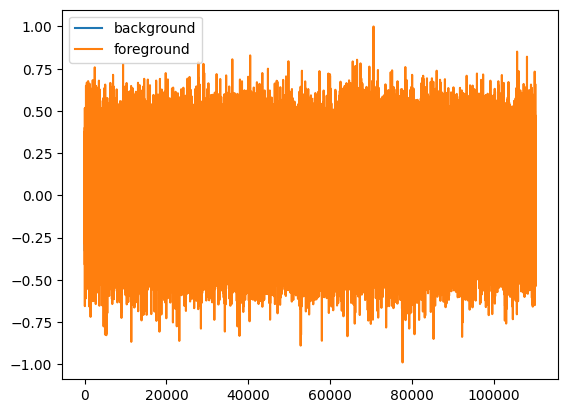

In [118]:
plt.plot(bg_event, label='background')
plt.plot(fg_event, label='foreground')
plt.legend()